In [69]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import namedtuple

from onms_decoder import OnmsDecoder
from awgn import Awgn
from bpsk import Bpsk
from awgn_llr_adapter import AwgnLlrAdapter


In [70]:
Settings = namedtuple('Settings', 'max_iter rejections_count snr_array')

In [78]:
def get_sigma(snr):
    return np.sqrt(10 ** (-snr/10)/2)

def simulate(settings, codeword, modulation, channel, decoder, decoder_adapter=None):
    
    simulations_count = len(settings.snr_array)
    fers = []
    is_max_iteration_reached = []
    sigmas = []
    
    for snr in settings.snr_array:
        
        sigma = get_sigma(snr)
        channel.sigma = sigma
        decoder_adapter.sigma = sigma
        
        errors_count = 0
        iterations_count = 0
        
        while (errors_count <= settings.rejections_count) and (iterations_count < settings.max_iter): 
            modulated = modulation.modulate(codeword);
            transmitted = channel.simulate(modulated);
            
            if decoder_adapter is not None:
                transmitted = decoder_adapter.adapt(transmitted)

            decoded = decoder.decode(transmitted)
            errors_count += not decoded[0]
            iterations_count += 1
        
        fer = errors_count / iterations_count
        fers.append(fer)
        is_max_iteration_reached.append(settings.max_iter == iterations_count)
        sigmas.append(sigma)
        
    return {'snr': settings.snr_array.copy(),
            'sigmas' : sigma,
            'fers':fers,
            'is_max_iteration_reached':is_max_iteration_reached }

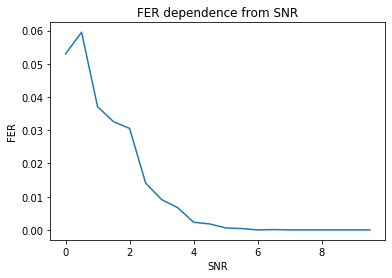

In [80]:
H = np.array([[1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0]])
codeword = np.array([0, 0, 1, 1, 1, 0])

decoder = OnmsDecoder(H);
channel = Awgn()
modulation = Bpsk()
adapter = AwgnLlrAdapter()

snr_min = 0
snr_max = 10
snr_step = 1
max_iterations_count = 10000
fer_threshold = 30

settings = Settings(
    max_iterations_count,
    fer_threshold,
    np.arange(snr_min, snr_max, snr_step))

result = simulate(settings, codeword, modulation, channel, decoder, adapter)

plt.plot(result['snr'], result['fers'])
plt.xlabel("SNR")
plt.ylabel("FER")
plt.title("FER dependence from SNR");